<a href="https://colab.research.google.com/github/duwcston/Image-Classification-Using-Pets-Dataset/blob/main/MobileNet_V2_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks')

In [ ]:
!ls

 chihuahua1_0.jpg					   Models	'TMC Lab'
'Image Classification on Oxford-IIIT Pets Dataset.ipynb'   Pug-4.jpg
 MobileNet_V2_Classification.ipynb			   samoyed.jpg


In [ ]:
# Import neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import callbacks
from keras import layers, models
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:80%]',
                                                          'train[80%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Returns (image, label)
                                                    with_info=True # To retrieve dataset info and label names
                                                    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCPTVHQ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCPTVHQ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 224

# Resize images
def resize(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_ds = train_raw.map(resize)
val_ds = val_raw.map(resize)
test_ds = test_raw.map(resize)

In [ ]:
# Encoding the target label
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
num_classes = 37

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(factor=(-0.025, 0.025)),
     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.RandomContrast(factor=0.1),
     ])

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_ds = train_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
IMG_SIZE = 224

base_model = keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False, weights="imagenet")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

In [ ]:
# Create new model on top
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

In [ ]:
x = keras.applications.mobilenet_v2.preprocess_input(x)

In [ ]:
x = base_model(x, training=False)

In [ ]:
x.shape

TensorShape([None, 7, 7, 1280])

In [ ]:
# Rebuild top layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

In [ ]:
EPOCHS = 15

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1,
                    callbacks =[earlystopping])

Epoch 1/15
92/92 [==============================] - 216s 2s/step - loss: 1.3653 - categorical_accuracy: 0.6223 - val_loss: 0.6095 - val_categorical_accuracy: 0.8478
Epoch 2/15
92/92 [==============================] - 194s 2s/step - loss: 0.4162 - categorical_accuracy: 0.8614 - val_loss: 0.4072 - val_categorical_accuracy: 0.8804
Epoch 3/15
92/92 [==============================] - 193s 2s/step - loss: 0.2833 - categorical_accuracy: 0.9069 - val_loss: 0.3923 - val_categorical_accuracy: 0.8791
Epoch 4/15
92/92 [==============================] - 193s 2s/step - loss: 0.2166 - categorical_accuracy: 0.9276 - val_loss: 0.3730 - val_categorical_accuracy: 0.8886
Epoch 5/15
92/92 [==============================] - 195s 2s/step - loss: 0.1817 - categorical_accuracy: 0.9385 - val_loss: 0.3754 - val_categorical_accuracy: 0.8886
Epoch 6/15
92/92 [==============================] - 197s 2s/step - loss: 0.1548 - categorical_accuracy: 0.9504 - val_loss: 0.3625 - val_categorical_accuracy: 0.8940
Epoch 7/15

In [ ]:
model.save('Models/MobileNet_V2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


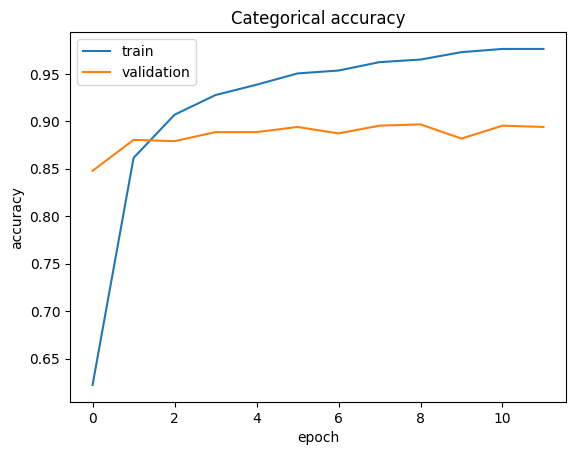

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

### Test on new instances

In [ ]:
from keras.preprocessing import image


# Load the saved model
loaded_model = keras.models.load_model('Models/MobileNet_V2.h5')

# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    plt.imshow(img_array/255)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape
    return img_array

# Function to make predictions
def predict_image(img_array):
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Get the index of the class with highest probability
    return predicted_class

1/1 [==============================] - 1s 1s/step
Predicted class index: 29
Predicted class: samoyed


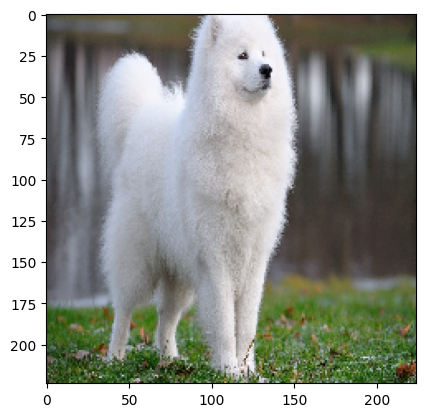

In [ ]:
uploaded_file_path = "Samples/samoyed.jpg"

# Preprocess the uploaded image
preprocessed_img = preprocess_image(uploaded_file_path)

class_names = ds_info.features['label'].names

# Make predictions
predicted_class = predict_image(preprocessed_img)

# Display the prediction
print("Predicted class index:", predicted_class)

# Function to map class index to class name
def get_class_name(class_index):
    return class_names[class_index]

# Example usage:
predicted_class_name = get_class_name(predicted_class)

# Print the actual name of the predicted class
print("Predicted class:", predicted_class_name)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get the ground truth labels and predicted labels for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = loaded_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.tight_layout()
plt.show()

# Generate classification report
cls_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(cls_report)

1/1 [==============================] - 1s 1s/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets